In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# 加载数据
df_Ballycotton = pd.read_csv("./dataProcessed/IrishNationalTideGaugeNetwork_Ballycotton Harbour2017.csv",encoding = "utf-8",)
# 转化为时间序列
df_Ballycotton['time'] = pd.to_datetime(df_Ballycotton['time'])
# 设置时间索引
df_Ballycotton = df_Ballycotton.set_index("time")


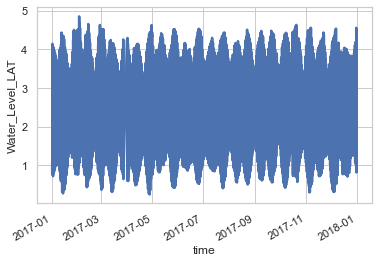

In [24]:
# 画图
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.set_theme(style="whitegrid")
dataPlot = df_Ballycotton.loc[:,"Water_Level_LAT"]
sns.lineplot(data=dataPlot, palette="tab10", linewidth=2.5,ax=ax)
# 将x轴斜过来显示更好看
fig.autofmt_xdate()

In [5]:
# 数据缺失情况
sum(df_Ballycotton.loc[:,'Water_Level_LAT'].isna())

0

Data loading...


100%|██████████| 19306/19306 [00:00<00:00, 877390.35it/s]

测试集大小为5792
Model loading...


Training...
Epoch: 0 batch: 0 | loss: 0.08782907575368881
Epoch: 0 batch: 10 | loss: 0.2316201776266098
Epoch: 0 batch: 20 | loss: 0.32755622267723083
Epoch: 0 batch: 30 | loss: 0.028000937774777412
Epoch: 0 batch: 40 | loss: 0.29413914680480957
Epoch: 0 batch: 50 | loss: 0.005339756142348051
Epoch: 0 batch: 60 | loss: 0.15144415199756622
Epoch: 0 batch: 70 | loss: 0.012190651148557663
Epoch: 0 batch: 80 | loss: 0.0693591833114624
Epoch: 0 batch: 90 | loss: 0.012628059834241867
Epoch: 0 batch: 100 | loss: 0.09249316900968552
Epoch: 0 batch: 110 | loss: 0.06774578988552094
Epoch: 0 batch: 120 | loss: 0.005496649537235498
Epoch: 0 batch: 130 | loss: 0.04678397253155708
Epoch: 0 batch: 140 | loss: 0.04011828824877739
Epoch: 0 batch: 150 | loss: 0.009639780968427658
Epoch: 0 batch: 160 | loss: 0.030301276594400406
Epoch: 0 batch: 170 | loss: 0.005477926228195429
Epoch: 0 batch: 180 | loss: 0.03001968376338482
Epoch: 0 batch: 190 | loss: 0.06367579102516174
Epoch: 0 batch: 200 | loss: 0.035

181it [00:01, 109.40it/s]


r2Score:  0.9697342369182097


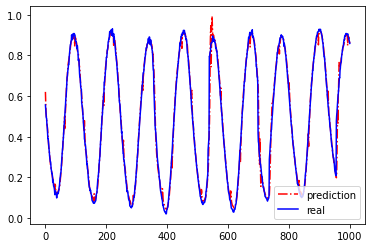

In [1]:
import torch
from torch.utils.data import DataLoader

from config import Config

from utils.dataTools import *
from utils.models import lstm_reg
from utils.trainer import train,evaluate

if __name__ == '__main__':
    config = Config()

    print("Data loading...")
    # 序列数据
    dataset = mydataReader("./dataProcessed/testData.csv")

    # 创建X/Y
    # 划分训练集和测试集，70% 作为训练集
    (train_X ,train_Y ),(test_X ,test_Y )= dataset.split(lookback=10,trainSet_ratio=0.7)

    # 创建Pytorch使用的dataset
    trainSet = custom_dataset(train_X,train_Y,lookback=10)
    testSet = custom_dataset(test_X,test_Y,lookback=10)

    train_loader = DataLoader(trainSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=4, drop_last=True)
    test_loader = DataLoader(testSet, batch_size = config.batch_size,
                            shuffle=False, pin_memory=True, num_workers=4, drop_last=False)

    print("Model loading...")
    model = lstm_reg(10,12).to(config.device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                 lr=config.learning_rate, weight_decay=config.weight_decay)

    print("Training...")
    model = train(model,
                  loader=train_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  config=config)

    print("Testing...", round(len(testSet)/config.batch_size))
    evaluate(model, test_loader, config)
